In [1]:
import numpy as np
import xarray as xr
from scipy import signal
import scipy.ndimage as im

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# generate a synthetic dataset

# Testing array
shape = (24*10, 30, 40)
dims = ('time', 'y', 'x')
#
time = pd.date_range('2000-01-01', periods=shape[0], freq='h')
y = np.linspace(0.01, 0.5, 30)
x = np.pi * np.linspace(0, 2, 40)
coords = {'time': time, 'y': y, 'x': x}
#
d = xr.DataArray(np.random.randn(*shape), dims=dims, coords=coords)
#
d = d.assign_coords(times=xr.DataArray((time-time[0]).seconds, 
                                       dims='time', coords={'time': time}))
d = d + np.cos(2.*np.pi*d.times/24./3600.)
#
d = d.chunk({'x':10})

In [3]:
print(d)

<xarray.DataArray (time: 240, y: 30, x: 40)>
dask.array<shape=(240, 30, 40), dtype=float64, chunksize=(240, 30, 10)>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-01T01:00:00 ...
  * y        (y) float64 0.01 0.0269 0.04379 0.06069 0.07759 0.09448 0.1114 ...
  * x        (x) float64 0.0 0.1611 0.3222 0.4833 0.6444 0.8055 0.9666 1.128 ...
    times    (time) int64 dask.array<shape=(240,), chunksize=(240,)>


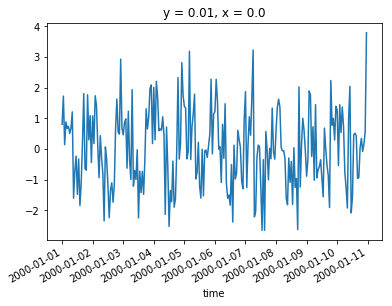

In [4]:
d.isel(x=0, y=0).plot()
#d.isel(x=10).mean(dim='y').plot()

In [5]:
dt = (time[1]-time[0]).seconds
h = signal.firwin(24*5, cutoff=[1./(30.*3600.),1./(20.*3600.)], pass_zero=False, nyq=1./2/dt, scale=True)
#h = h/h.sum()

#def firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=True,
#           scale=True, nyq=None, fs=None):

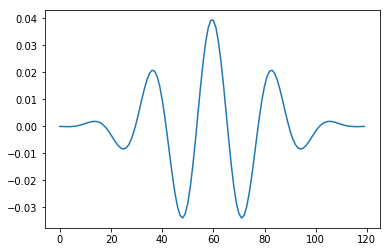

In [6]:
plt.plot(h)

In [7]:
def conv(x):
    return im.convolve1d(x, h, axis=2, mode='constant')

In [8]:
df = xr.apply_ufunc(conv, d,
                   dask='parallelized', output_dtypes=[float],
                   input_core_dims=[['time']],
                   output_core_dims=[['time']],
                   output_sizes={'time': len(d.time)})

In [9]:
print(d)
print(df)

<xarray.DataArray (time: 240, y: 30, x: 40)>
dask.array<shape=(240, 30, 40), dtype=float64, chunksize=(240, 30, 10)>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-01T01:00:00 ...
  * y        (y) float64 0.01 0.0269 0.04379 0.06069 0.07759 0.09448 0.1114 ...
  * x        (x) float64 0.0 0.1611 0.3222 0.4833 0.6444 0.8055 0.9666 1.128 ...
    times    (time) int64 dask.array<shape=(240,), chunksize=(240,)>
<xarray.DataArray (y: 30, x: 40, time: 240)>
dask.array<shape=(30, 40, 240), dtype=float64, chunksize=(30, 10, 240)>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-01T01:00:00 ...
  * y        (y) float64 0.01 0.0269 0.04379 0.06069 0.07759 0.09448 0.1114 ...
  * x        (x) float64 0.0 0.1611 0.3222 0.4833 0.6444 0.8055 0.9666 1.128 ...
    times    (time) int64 dask.array<shape=(240,), chunksize=(240,)>


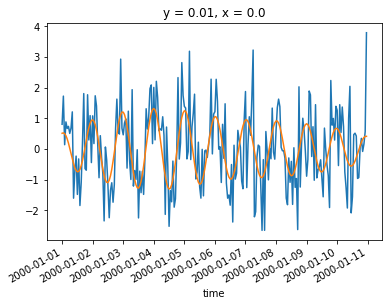

In [10]:
d.isel(x=0, y=0).plot()
df.isel(x=0, y=0).plot()